In [1]:
import pandas as pd
import numpy as np
import os
import copy
import time

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
import torchvision
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_curve, roc_auc_score
from mlxtend.plotting import plot_confusion_matrix

from tqdm import tqdm

import Config
import Utils

DATA_FILE_PATH = Config.DATA_FILE_PATH_CONTINUOUS_RESAMPLED
# DATA_FILE_PATH = Config.DATA_FILE_PATH_CONTINUOUS_EXTRACTED
LABEL_FILE_PATH = Config.LABEL_FILE_PATH
BATCH_SIZE = 512

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using:', device)

Using: cuda


In [2]:
def minmax_norm(df):
    return (df - df.min()) / ( df.max() - df.min())

file_name = 'continuousrri'
# file_name = 'continuousheartrate'
label_name = 'PHQ9'
data = pd.DataFrame()
labels = []
df_label = pd.read_csv(f"{LABEL_FILE_PATH}/scale.csv", encoding="utf-8")
ex_id_list = [int(_.split('.')[0]) for _ in os.listdir(f"{DATA_FILE_PATH}/{file_name}")[:-1]]
# ex_id_list = [int(_.split('.')[0]) for _ in os.listdir(f"{DATA_FILE_PATH}/{file_name}")]
ex_id_list.sort()
print('loading data:')
for ex_id in tqdm(ex_id_list):
    label_before = 0
    label_after = 0
    if label_name == 'PHQ9':
        label_before = 1 if df_label.loc[df_label['external_id'] == ex_id, label_name + '-1'].item() > 4 else 0
        label_after = 1 if df_label.loc[df_label['external_id'] == ex_id, label_name + '-2'].item() > 4 else 0
    
    df_data = pd.read_csv(f"{DATA_FILE_PATH}/{file_name}/{ex_id}.csv", encoding="utf-8").drop('timestamp', axis=1)
    
    # labels += [label_before if _ < 15 else label_after for _ in range(31)]
    # data = pd.concat([data, df_data], axis=0, ignore_index=True)
    
    df_before = df_data[:7 * 18 * 60 * 60]
    df_before = df_before[df_before['missing'] == 0]
    df_after = df_data[:-7 * 18 * 60 * 60]
    df_after = df_after[df_after['missing'] == 0]
    for df in [df_before, df_after]:
        df = df.drop(['missing'], axis=1)
        data = pd.concat([data, df[:int(df.shape[0] / 1800) * 1800]], axis=0, ignore_index=True)
        labels += [label_before if df is df_before else label_after for _ in range(int(df.shape[0] / 1800))]

    # df_data = pd.read_csv(f"{DATA_FILE_PATH}/{file_name}/{ex_id}.csv", encoding="utf-8")
    # # df_data = Utils.abnormal_processing(df_data, 'rri', Utils.mask_over_3std, Utils.fill_nearest)
    # # df_data = df_data[df_data['sqi'] == 100]
    # df_data = df_data.sort_values(by=['timestamp'])

    # df_before = df_data[df_data['timestamp'] < 1637510400000]
    # df_after = df_data[df_data['timestamp'] >= 1638979200000]
    # for df in [df_before, df_after]:
    #     # df = df.drop(['sqi', 'timestamp'], axis=1)
    #     df = df.drop(['timestamp'], axis=1)
    #     data = pd.concat([data, df[:int(df.shape[0] / 15) * 15]], axis=0, ignore_index=True)
    #     labels += [label_before if df is df_before else label_after for _ in range(int(df.shape[0] / 15))]

data['rri'] = minmax_norm(data['rri'])
# data['heartRate(beats/min)'] = minmax_norm(data['heartRate(beats/min)'])
data['sqi'] = minmax_norm(data['sqi'])

loading data:


100%|██████████| 58/58 [01:00<00:00,  1.04s/it]


In [3]:
# X = torch.Tensor(data.values).unsqueeze(0).view(31 * len(ex_id_list), 64800, 3).transpose(1, 2).unsqueeze(2).view(31 * len(ex_id_list), 3, 3600, 18)
X = torch.Tensor(data.values).unsqueeze(0).view(-1, 1800, 2).transpose(1, 2)
# X = torch.Tensor(data.values).unsqueeze(0).view(-1, 30, 1)
Y = torch.Tensor(labels)
print(X.shape, Y.shape)
print((Y.sum() / (Y.shape[0])).item() * 100)

torch.Size([31213, 2, 1800]) torch.Size([31213])
55.009132623672485


In [4]:
class RRIDataset(Dataset):
    def __init__(self, data, labels):
        self.X = data
        self.Y = labels

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

    def __len__(self):
        return self.X.size(0)

In [5]:
temp_dataset = RRIDataset(X[:10], Y[:10])
temp_loader = DataLoader(dataset=temp_dataset, batch_size=BATCH_SIZE, shuffle=True)
temp, temp_label = iter(temp_loader).next()
temp, temp_label = temp.to(device), temp_label.to(device)

In [5]:
def linear_combination(x, y, epsilon): 
    return epsilon*x + (1-epsilon)*y

def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss


class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon:float=0.1, reduction='mean'):
        super().__init__()
        self.epsilon = epsilon
        self.reduction = reduction
    
    def forward(self, preds, target):
        n = preds.size()[-1]
        log_preds = F.log_softmax(preds, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return linear_combination(loss/n, nll, self.epsilon)

In [14]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, (16, 1))
        self.conv2 = nn.Conv2d(6, 12, (16, 1))
        self.fc1 = nn.Linear(12 * 140 * 18, 1680)  # 30240, 1680
        self.fc2 = nn.Linear(1680, 140)
        self.fc3 = nn.Linear(140, 10)
        self.fc4 = nn.Linear(10, 2)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (5, 1))
        x = F.max_pool2d(F.relu(self.conv2(x)), (5, 1))
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = Model().to(device)
temp_pred = model(temp)

RuntimeError: Given groups=1, weight of size [6, 3, 16, 1], expected input[10, 2, 1800, 1] to have 3 channels, but got 2 channels instead

In [28]:
class BiLSTM(nn.Module):
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.BiLSTM = nn.LSTM(1, 16, batch_first=True, bidirectional=True, num_layers=2, dropout=0.2)
        self.classification = nn.Sequential(nn.Linear(32, 8), nn.ReLU(), nn.Dropout(p=0.5),
                                            nn.Linear(8, 4), nn.ReLU(), nn.Dropout(p=0.5),
                                            nn.Linear(4, 2))
    
    def forward(self, x):
        # print(x.shape)
        x, hidden = self.BiLSTM(x)
        # print(x.shape)
        x = self.classification(x)
        # print(x.shape)
        x = x[:, -1, :]
        # print(x.shape)
        return x

model = BiLSTM().to(device)
temp_pred = model(temp)

In [6]:
class CNN_BiLSTM(nn.Module):
    def __init__(self):
        super(CNN_BiLSTM, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, (16, 1))
        self.conv2 = nn.Conv2d(4, 16, (16, 1))
        self.conv3 = nn.Conv2d(16, 64, (8, 1))
        self.bn1 = nn.BatchNorm2d(4)
        self.bn2 = nn.BatchNorm2d(64)
        self.BiLSTM = nn.LSTM(128, 31, batch_first=True, bidirectional=True, num_layers=2, dropout=0.2)
        self.fc1 = nn.Linear(62, 62 // 4)
        self.fc2 = nn.Linear(62 // 4, 62 // 16)
        self.fc3 = nn.Linear(62 // 16, 2)
        self.classification = nn.Sequential(nn.Linear(62 * 62, 62 * 2), nn.ReLU(), nn.Dropout(p=0.2),
                                            nn.Linear(62 * 2, 4), nn.ReLU(), nn.Dropout(p=0.2),
                                            nn.Linear(4, 2))
    
    def forward(self, x):
        # print(x.shape)
        x = x.unsqueeze(3).transpose(1, 3)
        # print(x.shape)
        x = F.avg_pool2d(self.bn1(self.conv1(x)), (3, 1))
        # print(x.shape)
        x = F.avg_pool2d(F.relu(self.conv2(x)), (3, 1))
        # print(x.shape)
        x = F.avg_pool2d(self.bn2(self.conv3(x)), (3, 1))
        # print(x.shape)
        x = x.view(x.shape[0], 1, 62, -1).squeeze(1)
        # print(x.shape)
        x, hidden = self.BiLSTM(x)
        # print(x.shape)
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        x = x.reshape(x.shape[0], -1)
        # print(x.shape)
        x = self.classification(x)
        # print(x.shape)
        # x = x[:, -1, :]
        # print(x.shape)
        return x

model = CNN_BiLSTM().to(device)
temp_pred = model(temp)
criterion = nn.CrossEntropyLoss()
criterion(temp_pred, temp_label.long())

tensor(0.6060, device='cuda:0', grad_fn=<NllLossBackward0>)

In [6]:
class CNN_BiLSTM(nn.Module):
    def __init__(self):
        super(CNN_BiLSTM, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, (3, 1))
        self.conv2 = nn.Conv2d(4, 16, (3, 1))
        self.BiLSTM = nn.LSTM(16, 32, batch_first=True, bidirectional=True, num_layers=2, dropout=0.2)
        self.fc1 = nn.Linear(64, 16)
        self.fc2 = nn.Linear(16, 4)
        self.fc3 = nn.Linear(4, 2)
    
    def forward(self, x):
        # print(x.shape)
        x = x.transpose(1, 2).unsqueeze(3)
        # print(x.shape)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 1))
        # print(x.shape)
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 1))
        # print(x.shape)
        x = x.squeeze(3).transpose(1, 2)
        # print(x.shape)
        x, hidden = self.BiLSTM(x)
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # print(x.shape)
        x = x[:, -1, :]
        # print(x.shape)
        return x

model = CNN_BiLSTM().to(device)
temp_pred = model(temp)
criterion = nn.CrossEntropyLoss()
criterion(temp_pred, temp_label.long())

tensor(0.6586, device='cuda:0', grad_fn=<NllLossBackward0>)

In [32]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, (16, 1))
        self.conv2 = nn.Conv2d(16, 64, (16, 1))
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 68, 272)  # 30240, 1680
        self.fc2 = nn.Linear(272, 17)
        self.fc3 = nn.Linear(17, 2)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (5, 1))
        x = F.max_pool2d(F.relu(self.conv2(x)), (5, 1))
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CNN().to(device)
temp_pred = model(temp)

In [7]:
def init_network(model, method='xavier'):
    for name, w in model.named_parameters():
        if len(w.size()) < 2:
            continue
        if 'weight' in name:
            if method == 'xavier':
                nn.init.xavier_normal_(w)
            elif method == 'kaiming':
                nn.init.kaiming_normal_(w)
            else:
                nn.init.normal_(w)
        elif 'bias' in name:
            nn.init.constant_(w, 0)
        else:
            pass
    return model

In [25]:
dataset = RRIDataset(X, Y)
train_dataset, val_dataset = train_test_split(dataset, test_size=0.3, shuffle=True)
dataset_sizes = {'train':len(train_dataset), 'val':len(val_dataset)}
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [32]:
loaders = {'train': train_loader, 'val': val_loader}
losses = {'train': [], 'val': []}
accuracies = {'train': [], 'val': []}
def train(model, criterion, optimizer, scheduler, epochs=10):
    since = time.time()
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 32767
    final_epoch = 0
    patience_counter = 0
    for epoch in range(epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in loaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outp = model(inputs)
                    _, pred = torch.max(outp, 1)
                    loss = criterion(outp, labels.long())

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(pred == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)

            # if phase == 'train': print('Epoch: {}/{}'.format(epoch+1, epochs))
            # print('{} - loss:{:.3f}, accuracy:{:.3f}'.format(phase, epoch_loss, epoch_acc))

            # if phase == 'val' and epoch_acc > best_acc:
            #     best_acc = epoch_acc
            #     best_loss = epoch_loss
            #     best_model = copy.deepcopy(model.state_dict())
            #     patience_counter = 0
            # elif phase == 'val':
            #     patience_counter += 1
            if phase == 'val' and epoch_loss < best_loss:
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_model = copy.deepcopy(model.state_dict())
                patience_counter = 0
            elif phase == 'val':
                patience_counter += 1

        final_epoch = epoch
        # scheduler.step(epoch_acc)
        print(f'Epoch: {epoch + 1}/{epochs} patience: {patience_counter} train loss: {losses["train"][epoch]:.2f} train acc: {accuracies["train"][epoch]:.2f} valid loss: {losses["val"][epoch]:.2f} valid acc: {accuracies["val"][epoch]:.2f}')
        if patience_counter >= 5:
            print("early stop")
            break

    time_elapsed = time.time() - since

    print('Training Time {}m {}s'.format(int(time_elapsed // 60), round(time_elapsed % 60, 3)))
    print('Best valid accuracy {}'.format(best_acc))
    print('Best valid loss {}'.format(best_loss))

    model.load_state_dict(best_model)

    return model, final_epoch + 1

model = init_network(CNN_BiLSTM()).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)
model, epochs = train(model, criterion, optimizer, scheduler, 50)

Epoch: 1/50 patience: 0 train loss: 0.68 train acc: 0.55 valid loss: 0.71 valid acc: 0.56
Epoch: 2/50 patience: 0 train loss: 0.68 train acc: 0.55 valid loss: 0.68 valid acc: 0.56
Epoch: 3/50 patience: 0 train loss: 0.68 train acc: 0.55 valid loss: 0.67 valid acc: 0.56
Epoch: 4/50 patience: 0 train loss: 0.67 train acc: 0.55 valid loss: 0.67 valid acc: 0.56
Epoch: 5/50 patience: 1 train loss: 0.67 train acc: 0.55 valid loss: 0.67 valid acc: 0.56
Epoch: 6/50 patience: 0 train loss: 0.67 train acc: 0.55 valid loss: 0.66 valid acc: 0.56
Epoch: 7/50 patience: 0 train loss: 0.67 train acc: 0.56 valid loss: 0.66 valid acc: 0.59
Epoch: 8/50 patience: 1 train loss: 0.66 train acc: 0.57 valid loss: 0.66 valid acc: 0.59
Epoch: 9/50 patience: 0 train loss: 0.66 train acc: 0.58 valid loss: 0.66 valid acc: 0.59
Epoch: 10/50 patience: 1 train loss: 0.65 train acc: 0.59 valid loss: 0.67 valid acc: 0.57
Epoch: 11/50 patience: 2 train loss: 0.64 train acc: 0.59 valid loss: 0.66 valid acc: 0.58
Epoch: 1

In [27]:
def train(model, optimizer, criterion, X_train, Y_train, X_val, Y_val, epochs=10):
    train_dataset = RRIDataset(X_train, Y_train)
    valid_dataset = RRIDataset(X_val, Y_val)
    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
    loaders = {'train': train_loader, 'valid': valid_loader}
    dataset_sizes = {'train':len(train_dataset), 'valid':len(valid_dataset)}
    
    losses = {'train': [], 'valid': []}
    accuracies = {'train': [], 'valid': []}
    best_acc = 0.0
    best_model = None
    for epoch in tqdm(range(epochs)):
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in loaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outp = model(inputs)
                    _, pred = torch.max(outp, 1)
                    loss = criterion(outp, labels.long())

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(pred == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)

            # if phase == 'train': print('Epoch: {}/{}'.format(epoch+1, epochs))
            # print('{} - loss:{:.2f}, accuracy:{:.2f}'.format(phase, epoch_loss, epoch_acc))

            # if phase == 'valid':
            #     print('Time: {}m {}s'.format(int((time.time() - since) // 60), round((time.time() - since) % 60), 2))

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
    
    model.load_state_dict(best_model)
    return losses['train'], losses['valid'], accuracies['train'], accuracies['valid'], best_acc, model

def get_kfold_data(k, i, X, Y):  
    # 返回第 i+1 折 (i = 0 -> k-1) 交叉验证时所需要的训练和验证数据
    fold_size = X.shape[0] // k  # 每份的个数:数据总条数/折数（组数）
    valid_start = i * fold_size
    if i != k - 1:
        valid_end = (i + 1) * fold_size
        X_val, Y_val = X[valid_start: valid_end], Y[valid_start: valid_end]
        X_train = torch.cat((X[0: valid_start], X[valid_end:]), dim = 0)
        Y_train = torch.cat((Y[0: valid_start], Y[valid_end:]), dim = 0)
    else:  # 若是最后一折交叉验证
        X_val, Y_val = X[valid_start:], Y[valid_start:]     # 若不能整除，将多的case放在最后一折里
        X_train = X[0: valid_start]
        Y_train = Y[0: valid_start]
       
    return X_train, Y_train, X_val, Y_val

def k_fold(X_train, Y_train, k):
    train_loss_sum, valid_loss_sum = 0, 0
    train_acc_sum, valid_acc_sum = 0, 0
    
    all_best_acc = 0.0
    all_bset_model = None
    best_k = 0
    for i in range(k):
        print(f'{i + 1} fold')
        data = get_kfold_data(k, i, X_train, Y_train)
        model = init_network(Model()).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()
        train_loss, valid_loss, train_acc, valid_acc, best_acc, best_model = train(model, optimizer, criterion, *data)
       
        print('train loss:{:.3f}, train accuracy:{:.3f}%'.format(train_loss[-1], train_acc[-1]*100))
        print('valid loss:{:.3f}, valid accuracy:{:.3f}%\n'.format(valid_loss[-1], valid_acc[-1]*100))
       
        train_loss_sum += train_loss[-1]
        valid_loss_sum += valid_loss[-1]
        train_acc_sum += train_acc[-1]
        valid_acc_sum += valid_acc[-1]

        if best_acc > all_best_acc:
            all_best_acc = best_acc
            all_bset_model = best_model
            best_k = i
       
    print('final:')
    print('average train loss:{:.3f}, average train accuracy:{:.3f}%'.format(train_loss_sum/k, train_acc_sum/k*100))
    print('average valid loss:{:.3f}, average valid accuracy:{:.3f}%'.format(valid_loss_sum/k, valid_acc_sum/k*100))
    print('best valid accuracy:{:.3f}%'.format(all_best_acc))
    return all_bset_model, best_k

since = time.time()

model, best_k = k_fold(X, Y, 5)

time_elapsed = time.time() - since
print('Training Time {}m {}s'.format(int(time_elapsed // 60), round(time_elapsed % 60, 2)))

1 fold


NameError: name 'Model' is not defined

In [26]:
_, _, X_val, Y_val = get_kfold_data(5, best_k, X, Y)
valid_dataset = RRIDataset(X_val, Y_val)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

Accuracy: 59 %


<Figure size 640x480 with 0 Axes>

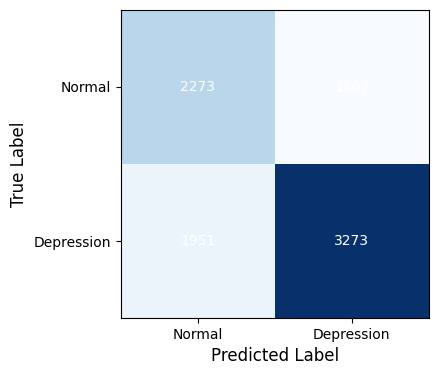

In [33]:
correct = 0
total = 0
all_labels = []
all_scores = []
all_preds = []
with torch.no_grad():
    for inputs in val_loader:
        test_inputs, test_labels = inputs
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        # print('True label:', ' '.join('%d' % labels[j] for j in range(len(labels))))
        outputs = model(test_inputs)
        _, preds = torch.max(outputs, 1)
        # print('Predicted label:', ' '.join('%d' % preds[j] for j in range(len(labels))))
        total += test_labels.size(0)
        correct += (preds == test_labels).sum()
        all_labels += test_labels.cpu()
        all_scores += [_[1] for _ in torch.nn.Softmax(dim=1)(outputs).cpu()]
        all_preds += preds.cpu()
print('Accuracy: %d %%' % (100 * correct / total))

cm = confusion_matrix(all_labels, all_preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(6, 4))#, cmap=plt.cm.Blues
plt.xticks(range(2), ['Normal', 'Depression'], fontsize=10)
plt.yticks(range(2), ['Normal', 'Depression'], fontsize=10)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

0.6742356802870983


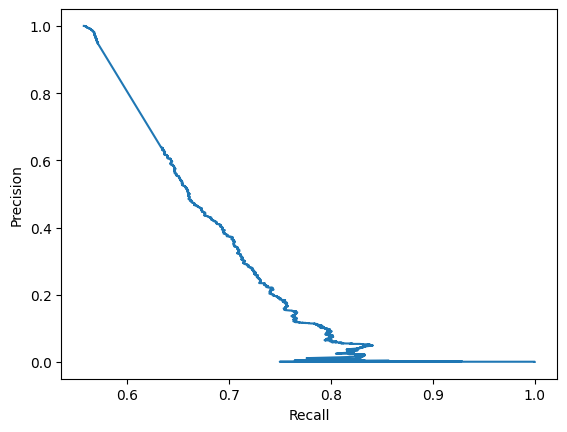

In [34]:
precision, recall, thresholds = precision_recall_curve(all_labels, all_scores)
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

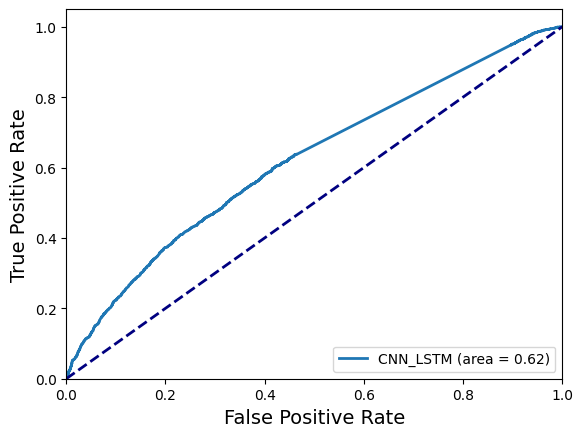

In [35]:
def roc_fig(y_label, y_pred, method_name):
    y_label = np.array(y_label)
    y_pred = np.array(y_pred)
    fpr = dict()
    tpr = dict() 
    roc_auc = dict()
    fpr[0], tpr[0], _ = roc_curve(y_label, y_pred)
    roc_auc[0] = auc(fpr[0], tpr[0])
    lw = 2
    plt.plot(fpr[0], tpr[0], lw=lw, label=method_name+' (area = %0.2f)'%roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(loc="lower right")
    return
roc_fig(all_labels, all_scores, "CNN_LSTM")

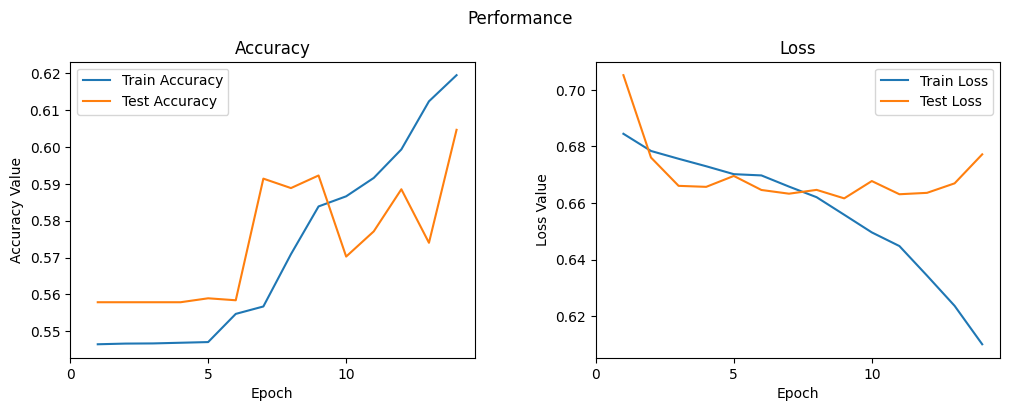

In [36]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1, epochs + 1))
ax1.plot(epoch_list, [_.cpu().item() for _ in accuracies['train']], label='Train Accuracy')
ax1.plot(epoch_list, [_.cpu().item() for _ in accuracies['val']], label='Test Accuracy')
ax1.set_xticks(np.arange(0, epochs + 1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, losses['train'], label='Train Loss')
ax2.plot(epoch_list, losses['val'], label='Test Loss')
ax2.set_xticks(np.arange(0, epochs + 1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [147]:
bestmodel = {
    'model': model,
    'state_dict': model.state_dict(),
    'optimizer' : optimizer.state_dict()
}
torch.save(bestmodel, './CNN_LSTM.pth')